# `Материалы кафедры ММП факультета ВМК МГУ. Введение в Эффективные Системы Глубокого Обучение.`

# `Семинар 06.2. Граф вычислений с точки зрения эффективности: использование autograd function`

### `Материалы составил Феоктистов Дмитрий (@trandelik)`

#### `Москва, Осенний семестр 2025`

О чём можно узнать из этого ноутбука:

* Как писать свои autograd function в PyTorch
* Как их использовать для квантизации и не только

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']

sns.set_style("whitegrid")

### `Setup`

Мы будем использовать простой набор данных moons из scikit-learn.

In [3]:
N_SAMPLES = 2000
NOISE = 0.1
RANDOM_STATE = 42
TEST_SIZE = 0.2
EPOCHS = 200
LR = 0.01
HIDDEN_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [4]:
X, y = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=RANDOM_STATE)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float().view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([1600, 2])
y_train shape: torch.Size([1600, 1])


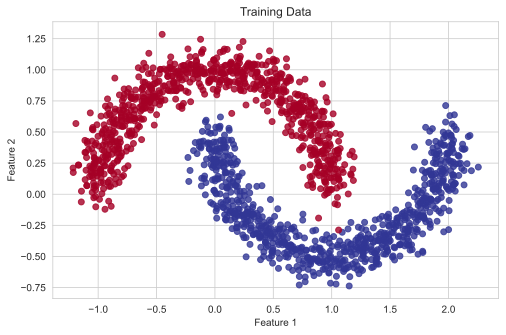

In [5]:
plt.figure(figsize=(8, 5))
plt.scatter(X_train.cpu()[:, 0], X_train.cpu()[:, 1], c=y_train.cpu().squeeze(), cmap=plt.cm.RdYlBu, alpha=0.8)
plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### `MLP`

In [6]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, HIDDEN_SIZE)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x

In [7]:
def train_model(model, X_train, y_train, epochs, lr):
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    model.train()
    for epoch in range(epochs):
        y_logits = model(X_train)
        loss = loss_fn(y_logits, y_train)
        loss_history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
            
    return loss_history

In [8]:
print("--- Base MLP ---")
baseline_model = BaselineMLP().to(device)
baseline_losses = train_model(baseline_model, X_train, y_train, EPOCHS, LR)

--- Base MLP ---
Epoch 20/200, Loss: 0.2321
Epoch 40/200, Loss: 0.1028
Epoch 60/200, Loss: 0.0289
Epoch 80/200, Loss: 0.0112
Epoch 100/200, Loss: 0.0072
Epoch 120/200, Loss: 0.0056
Epoch 140/200, Loss: 0.0047
Epoch 160/200, Loss: 0.0041
Epoch 180/200, Loss: 0.0037
Epoch 200/200, Loss: 0.0034


### `autograd.Function`

В PyTorch вычисления над тензорами образуют граф вычислений. Когда мы вызываем `loss.backward()`, PyTorch обходит этот граф в обратном порядке, вычисляя градиенты с помощью цепного правила (chain rule). Этот процесс называется **автоматическим дифференцированием**.

Однако стандартный `autograd` работает только для дифференцируемых операций. Если нам нужно:
1.  Встроить в модель **недифференцируемую операцию** (например, квантование с округлением).
2.  Сделать что-то после forward/перед backward (переложить данные на cpu/gpu; шардировать или дешардировать тензор; сделать checkpointing)
2.  **Изменить поведение градиента** для существующей операции (например, для стабилизации обучения).

Мы можем создать свою собственную операцию, унаследовав класс от `torch.autograd.Function`. Для этого нужно реализовать два статических метода:

- `forward(ctx, ...)`: Этот метод определяет логику **прямого прохода** (forward pass). 
  - `ctx` — это "контекстный" объект, в который можно сохранять любые тензоры, необходимые для обратного прохода. Например, входной тензор `x` сохраняется с помощью `ctx.save_for_backward(x)`.
 
- `backward(ctx, ...)`: Этот метод определяет логику **обратного прохода** (backward pass). 
  - Он получает `grad_output` — градиент, пришедший от последующих слоев.
  - Его задача — вычислить и вернуть градиент по отношению к каждому из входов функции `forward`. Для этого он может использовать сохраненные в `ctx` значения.  

Таким образом, `autograd.Function` позволяет нам "обмануть" PyTorch, вручную определив, как должен вычисляться градиент для нашей кастомной операции.

#### `Clipped Leaky ReLU`

В качестве примера создадим "асимметричную" функцию активации, которая ведет себя по-разному во время прямого и обратного проходов:

- **Прямой проход (Forward)**: **Clipped ReLU**. Это вариант ReLU, который ограничивает максимальное значение единицей. Функция выглядит как `min(max(0, x), 1)`. Это делает ее недифференцируемой в точках 0 и 1.
- **Обратный проход (Backward)**: Градиент от **Leaky ReLU**. Вместо реальной производной от Clipped ReLU (которая равна 0 для `x<0` и `x>1`), мы будем использовать градиент от Leaky ReLU. Его производная равна `1` для `x > 0` и небольшому положительному числу `alpha` (например, 0.01) для `x <= 0`. Это позволяет слабым градиентам "протекать" даже через зануленные нейроны.

In [9]:
class ClippedLeakyReluFunc(torch.autograd.Function):    
    @staticmethod
    def forward(ctx, x, alpha=0.01):
        ctx.save_for_backward(x)
        ctx.alpha = alpha
        return torch.clamp(x, min=0, max=1)

    @staticmethod
    def backward(ctx, grad_output):
        alpha = ctx.alpha
        x, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[x <=0] *= alpha
        return grad_input, None

#### `Квантизация и Straight-Through Estimator (STE)`

##### `FP8 quantization`

Сделаем симуляцию квантизации в формат FP8 E4M3. Это означает, что все вычисления продолжают выполняться в FP32, но значения тензоров приводятся к такой точности, как если бы они были в FP8. Это позволяет модели "привыкнуть" к потере точности во время обучения (Quantization-Aware Training, QAT).

Формат **E4M3** означает: 1 бит на знак, **4 бита на экспоненту**, **3 бита на мантиссу**.
Алгоритм симуляции в `FakeQuantizeFP8.forward` работает так:
1.  **Разложение**: Входное число FP32 раскладывается на знак, мантиссу и экспоненту с помощью `torch.frexp`.
2.  **Квантизация мантиссы**: Мантисса, имеющая 23 бита в FP32, округляется до 3-битной точности. Это главный источник потери информации.
3.  **Ограничение экспоненты**: Экспонента FP32 (8 бит) "обрезается" (`clamp`) до диапазона, представимого в 4 битах.
4.  **Сборка**: Новое число FP32 собирается обратно из знака, квантованной мантиссы и ограниченной экспоненты с помощью `torch.ldexp`.

##### `Straight-Through Estimator (STE)`

Проблема в том, что квантизация принципиально **недифференцируема**. Чтобы решить эту проблему, можно использовать STE:

-   **На прямом проходе (`forward`)**: Мы применяем недифференцируемую операцию (квантизацию).
-   **На обратном проходе (`backward`)**: Мы делаем вид, что этой операции не было, и считаем её производную равной 1. То есть, мы просто **копируем градиент** с выхода на вход без изменений (`grad_input = grad_output`).

Это позволяет градиентам "протекать" через слой квантования, и модель может обучаться, адаптируясь к потере точности.

In [10]:
class FakeQuantizeFP8(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # --- Параметры формата E4M3 ---
        mantissa_bits = 3
        
        # E4M3 использует смещение (bias) 7. Диапазон экспоненты для нормализованных чисел от [-6, 7].
        # torch.frexp возвращает экспоненту `exp`, такую что x = mantissa * 2**exp, где 0.5 <= |mantissa| < 1.
        # Это соответствует диапазону `exp` от [-5, 8] для формата E4M3.
        min_exp = -5 
        max_exp = 8
        
        # Количество уровней квантования для мантиссы (3 бита -> 8 уровней)
        mantissa_levels = 2**mantissa_bits

        # Обрабатываем нули отдельно, чтобы избежать проблем с log/frexp
        zero_mask = (x == 0)
        
        # Сохраняем знак и работаем с абсолютными значениями
        sign = torch.sign(x)
        x_abs = torch.abs(x)

        # Раскладываем число на мантиссу и экспоненту
        # x_abs = mantissa * 2**exponent
        mantissa, exponent = torch.frexp(x_abs)
        
        # Мантисса от frexp находится в диапазоне [0.5, 1.0). Квантуем этот диапазон.
        # Умножение на уровни, округление и обратное деление отображают её на дискретные шаги.
        mantissa_q = torch.round(mantissa * mantissa_levels) / mantissa_levels
        
        # Клипируем экспоненту диапазоном, представимым в E4M3.
        exponent_q = torch.clamp(exponent, min=min_exp, max=max_exp)

        # Собираем число из квантизованных мантиссы и экспоненты
        dequantized_abs = torch.ldexp(mantissa_q, exponent_q)
        
        # Применяем исходный знак
        dequantized = dequantized_abs * sign
        
        # Убеждаемся, что нули остались нулями
        dequantized[zero_mask] = 0.0
        
        return dequantized

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

### `QAT MLP с кастомными функциями`

Чтобы чисто использовать наши пользовательские функции, мы обернем их в модули `nn.Module`. Для функции квантизации нам потребуется создать кастомный линейный слой, поскольку мы хотим сжимать *веса* этого слоя, а не его активации.

In [11]:
class ClippedLeakyRelu(nn.Module):
    def forward(self, x):
        return ClippedLeakyReluFunc.apply(x)

In [12]:
class QuantizedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        quantized_weight = FakeQuantizeFP8.apply(self.linear.weight)
        return F.linear(x, quantized_weight, self.linear.bias)

In [13]:
class QAT_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = QuantizedLinear(2, HIDDEN_SIZE)
        self.custom_act1 = ClippedLeakyRelu()
        self.layer2 = QuantizedLinear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.custom_act2 = ClippedLeakyRelu()
        self.layer3 = QuantizedLinear(HIDDEN_SIZE, 1)

    def forward(self, x):
        x = self.custom_act1(self.layer1(x))
        x = self.custom_act2(self.layer2(x))
        x = self.layer3(x)
        return x

### `Обучение кастомной MLP`

In [14]:
print("--- QAT MLP ---")
qat_model = QAT_MLP().to(device)
qat_losses = train_model(qat_model, X_train, y_train, EPOCHS, LR)

--- QAT MLP ---
Epoch 20/200, Loss: 0.2757
Epoch 40/200, Loss: 0.1883
Epoch 60/200, Loss: 0.1493
Epoch 80/200, Loss: 0.0921
Epoch 100/200, Loss: 0.0640
Epoch 120/200, Loss: 0.0281
Epoch 140/200, Loss: 0.0207
Epoch 160/200, Loss: 0.0153
Epoch 180/200, Loss: 0.0158
Epoch 200/200, Loss: 0.0138


### `Сравнение`

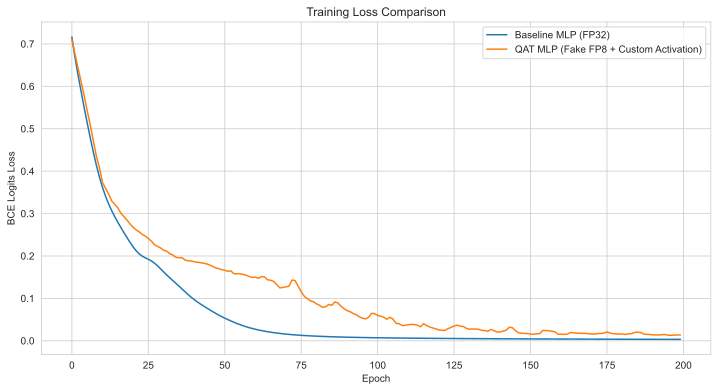

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(baseline_losses, label="Baseline MLP (FP32)")
plt.plot(qat_losses, label="QAT MLP (Fake FP8 + Custom Activation)")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("BCE Logits Loss")
plt.legend()
plt.show()

In [16]:
def evaluate_accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_logits = model(X_test)
        y_pred = torch.round(torch.sigmoid(y_logits))
        acc = accuracy_score(y_test.cpu(), y_pred.cpu())
    return acc

baseline_acc = evaluate_accuracy(baseline_model, X_test, y_test)
qat_acc = evaluate_accuracy(qat_model, X_test, y_test)

print(f"Baseline MLP Test Accuracy: {baseline_acc * 100:.2f}%")
print(f"QAT MLP Test Accuracy:      {qat_acc * 100:.2f}%")

Baseline MLP Test Accuracy: 100.00%
QAT MLP Test Accuracy:      99.75%


In [17]:
def plot_decision_boundary(model, X, y, title):
    model.to("cpu")
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = torch.sigmoid(Z).detach().numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    model.to(device)

/var/tmp/ipykernel_2364515/2108889467.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
/var/tmp/ipykernel_2364515/2108889467.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.arange(y_min, y_max, h))


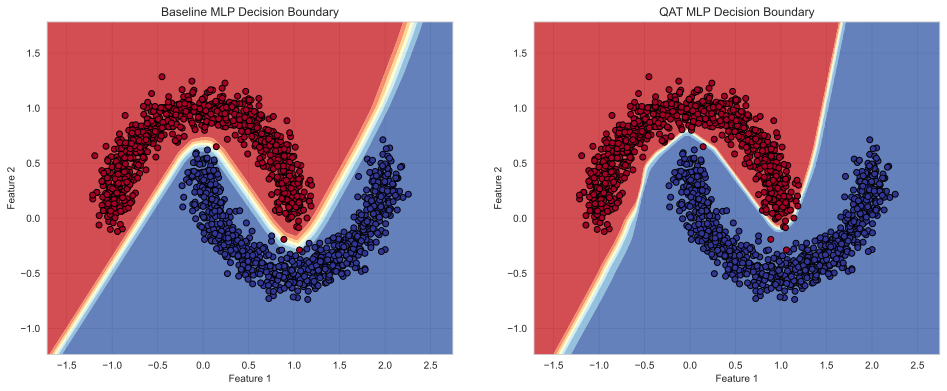

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plt.sca(axes[0])
plot_decision_boundary(baseline_model, X_train.cpu(), y_train.cpu(), "Baseline MLP Decision Boundary")

plt.sca(axes[1])
plot_decision_boundary(qat_model, X_train.cpu(), y_train.cpu(), "QAT MLP Decision Boundary")

plt.show()